In [2]:
import pickle
import pandas as pd
import os
import random
import cv2
from matplotlib import pyplot as plt
import splitfolders
import numpy as np
from torchsummary import summary
from torch import nn
import copy
import time
import timm
import torch
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import torch
from torch import nn, optim
import sys
from time import sleep
from datetime import datetime
from torchvision.datasets.folder import default_loader
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix




In [3]:
BASELINE = "baseline"
BILATERAL = "bilateral"
CANNY = 'canny'
CLAHE = 'clahe'


BATCH_SIZE = 64

## Necessary functions

In [7]:
class Dataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(Dataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        tensor = transforms.ToTensor()(img)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index
        
class NoiseReductionDataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(NoiseReductionDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        assert 'd' in parameter_dict
        assert 'sigmaColor' in parameter_dict
        assert 'sigmaSpace' in parameter_dict

        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
        self.d = parameter_dict['d']
        self.sigmaColor = parameter_dict['sigmaColor']
        self.sigmaSpace = parameter_dict['sigmaSpace']
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        ## OBS: not sure about d, sigmaColor and sigmaSpace (15, 75, 75)
        noiseless = cv2.bilateralFilter(img, self.d, self.sigmaColor, self.sigmaSpace)
        tensor = transforms.ToTensor()(noiseless)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

class EdgeDetectionDataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(EdgeDetectionDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        assert 'low_tresh' in parameter_dict
        assert 'high_tresh' in parameter_dict

        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        ## OBS: not sure about minVal and maxVal (100, 200) also need to look at aperture_size (size of Sobel kernel) and  L2gradient
        edge = cv2.Canny(img, parameter_dict['low_tresh'], parameter_dict['high_tresh'])
        tensor = transforms.ToTensor()(edge)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

class ContrastEnhancingDataset(datasets.ImageFolder):
    def __init__(self, root, parameter_dict, loader=default_loader, is_valid_file=None):
        super(ContrastEnhancingDataset, self).__init__(root=root, loader=loader, is_valid_file=is_valid_file)
        assert 'gray_scale' in parameter_dict
        assert 'clipLimit' in parameter_dict
        assert 'tileGridSize' in parameter_dict

        self.gray_scale = parameter_dict['gray_scale']
        self.mean = IMAGENET_DEFAULT_MEAN
        self.std = IMAGENET_DEFAULT_STD
    
    def __getitem__(self, index):
        image_path, target = self.samples[index]
        img = cv2.imread(image_path)
        if self.gray_scale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            self.mean = [0.5]
            self.std = [0.5]
        ## OBS: not sure about clipLimit=2.0, tileGridSize=(8,8)
        clahe = cv2.createCLAHE(clipLimit=parameter_dict['clipLimit'], tileGridSize=parameter_dict['tileGridSize'])
        enhanced = clahe.apply(img)
        tensor = transforms.ToTensor()(enhanced)
        sample = transforms.Normalize(self.mean, self.std)(tensor)
        return sample, target, index

In [8]:
def get_dataset(root_dir, mode, classe, parameter_dict):
    path = os.path.join(root_dir, mode)
    dataset = classe(path, parameter_dict)
    return dataset

def dataloader(root_dir, mode, classe, parameter_dict):
    dataset = get_dataset(root_dir, mode, classe, parameter_dict)
    # Can have batchsize in dataloader
    data_loader = DataLoader(
        dataset,
        batch_size = BATCH_SIZE,
        shuffle = True
    )
    return data_loader, dataset

In [11]:
class ConvolutionalNet(nn.Module):
    def __init__(self, gray_scale=False):
        super().__init__()
        input_dimention = 1 if gray_scale else 3
        self.conv1 = nn.Conv2d(input_dimention, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(73926, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Prediction on testset

In [15]:
# model_path = 'model_07_01_2022_15:52:55_model.pth'

model_path = 'models/bilateral_grey_20_01_2022_17:27:39_model.pth'

RUN_TYPE = BILATERAL
GRAY_SCALE = True
root_dir = 'Images'

In [13]:
model = torch.load(model_path)

In [16]:
if RUN_TYPE == BASELINE:
    dataloder_test, dataset_test = dataloader(root_dir, "test", Dataset, {'gray_scale': GRAY_SCALE})
elif RUN_TYPE == BILATERAL:
    # Bilateral
    parameter_dict = {'gray_scale': GRAY_SCALE, 'd': 15, 'sigmaColor': 50, 'sigmaSpace': 100}
    dataloder_test, dataset_test = dataloader(root_dir, "test", NoiseReductionDataset, parameter_dict )
elif RUN_TYPE == CANNY:
    parameter_dict = {'gray_scale': GRAY_SCALE, 'low_tresh': 50, 'high_tresh': 230}
    dataloder_test, dataset_test = dataloader(root_dir, "test", EdgeDetectionDataset, parameter_dict )
elif RUN_TYPE == CLAHE:
    parameter_dict = {'gray_scale': GRAY_SCALE, 'clipLimit': 1.0, 'tileGridSize': (8,8)}
    dataloder_test, dataset_test = dataloader(root_dir, "test", ContrastEnhancingDataset, parameter_dict )
else:
    raise Exception("Unknown run tpye")

print("testing ", RUN_TYPE, " with grayscale ", GRAY_SCALE)

testing  bilateral  with grayscale  True


In [19]:
print(f"Length of dataset: {len(dataset_test)}, classes in dataset: {dataset_test.classes}")
inputs, classes, indices = next(iter(dataloder_test))
print("Shape of image:", inputs.shape)

Length of dataset: 6000, classes in dataset: ['Negative', 'Positive']
Shape of image: torch.Size([64, 1, 227, 227])


In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in dataset_test.classes}
total_pred = {classname: 0 for classname in dataset_test.classes}
classlabels = {0: 'Negative', 1: 'Positive'}

full_pred_list = []
full_ground_truth = []
# again no gradients needed
i=0
with torch.no_grad():
    for data in dataloder_test:
        i+=1
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)

        # Print loading bar
        sys.stdout.write('\r')
        percentage = 100/len(dataset_test)*BATCH_SIZE*i
        sys.stdout.write("Prediction:[%-20s] %.2f%%" % ('='*round(percentage/5), percentage))
        sys.stdout.flush()


        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            full_pred_list.append(prediction.item())
            full_ground_truth.append(label.item())
            classs = label.item()
            if label == prediction:
                correct_pred[classlabels[classs]] += 1
            total_pred[classlabels[classs]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Prediction:[====================] 100.27%Accuracy for class Negative is: 98.9 %
Accuracy for class Positive is: 97.4 %


In [22]:
def plot_confusion_matrix(confusion_matrix):

    ax = sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')

    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [23]:
def evaluation(ground_truth, predictions):
    '''
        Function for plotting the confusion_matrix
        Inputs:
            predicitons: Predicitons from a keras model

    '''
    target_names = ['Negative (0)', 'Positive (1)']
    print(classification_report(ground_truth, predictions, target_names=target_names, digits=4))
    print(accuracy_score(ground_truth, predictions))
    cf_matrix = confusion_matrix(ground_truth, predictions)
    plot_confusion_matrix(cf_matrix)

              precision    recall  f1-score   support

Negative (0)     0.9747    0.9887    0.9816      3000
Positive (1)     0.9885    0.9743    0.9814      3000

    accuracy                         0.9815      6000
   macro avg     0.9816    0.9815    0.9815      6000
weighted avg     0.9816    0.9815    0.9815      6000

0.9815


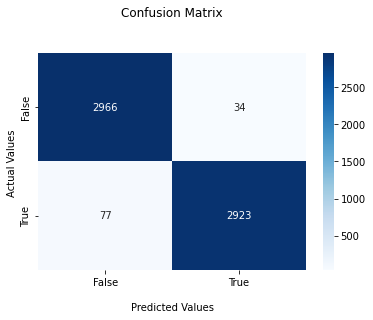

In [24]:
evaluation(full_ground_truth, full_pred_list)